In [6]:
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [7]:
dataset='../test'
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)
train_df, test_df = train_test_split(image_df, test_size=0.05, shuffle=True, random_state=42)

label_counts = image_df['Label'].value_counts()

label_counts

Label
ants            1000
bees            1000
snail           1000
wasp             996
moth             994
grasshopper      970
weevil           970
earwig           932
catterpillar     868
beetle           832
slug             782
earthworms       646
Name: count, dtype: int64

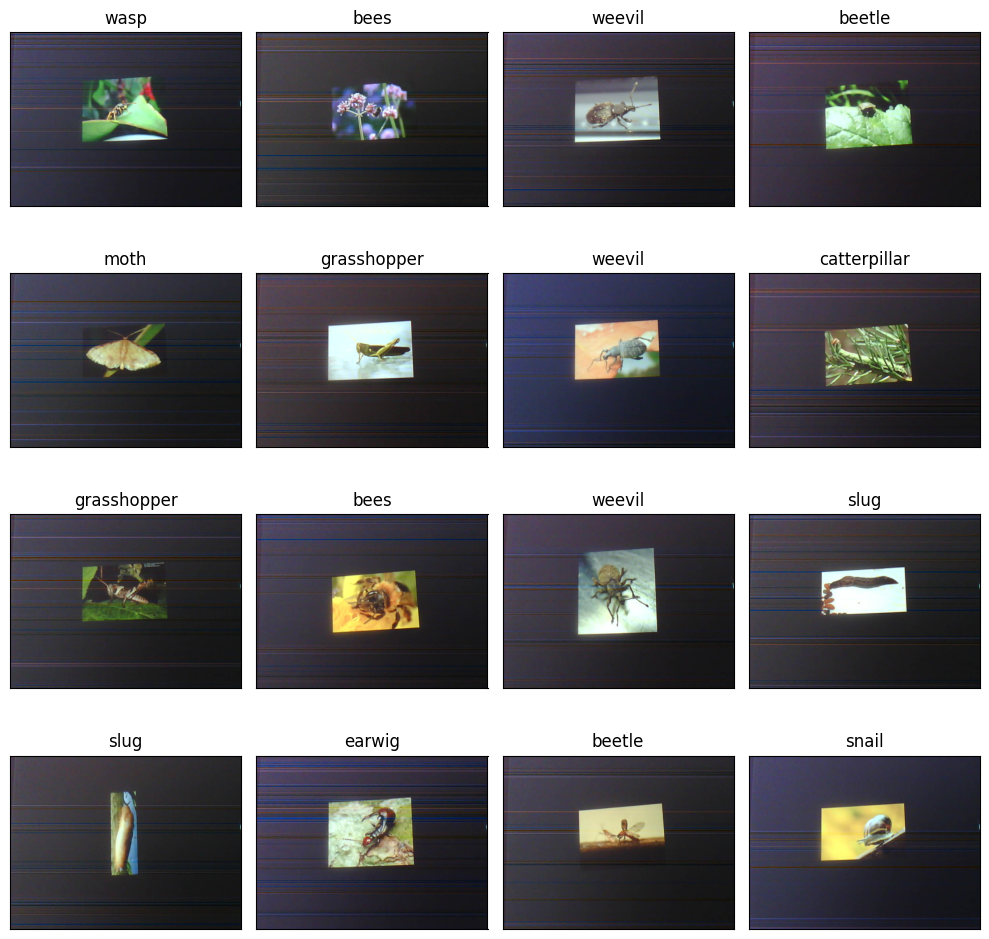

In [8]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

# Create a flow from dataframe for the test images
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=False
)

Found 10990 validated image filenames belonging to 12 classes.
Found 550 validated image filenames belonging to 12 classes.


In [10]:
train_images[1]

(array([[[[ 71.,  72.,  92.],
          [ 71.,  73.,  85.],
          [ 67.,  70.,  79.],
          ...,
          [ 42.,  40.,  45.],
          [ 41.,  39.,  44.],
          [ 39.,  37.,  42.]],
 
         [[ 78.,  67.,  83.],
          [ 78.,  68.,  76.],
          [ 78.,  69.,  74.],
          ...,
          [ 42.,  40.,  41.],
          [ 41.,  39.,  40.],
          [ 39.,  37.,  38.]],
 
         [[ 85.,  67.,  79.],
          [ 85.,  69.,  72.],
          [ 84.,  68.,  69.],
          ...,
          [ 42.,  41.,  37.],
          [ 41.,  40.,  36.],
          [ 39.,  38.,  34.]],
 
         ...,
 
         [[ 58.,  57.,  62.],
          [ 57.,  58.,  63.],
          [ 55.,  58.,  65.],
          ...,
          [ 22.,  23.,  17.],
          [ 19.,  19.,  17.],
          [ 19.,  17.,  28.]],
 
         [[ 59.,  57.,  62.],
          [ 59.,  56.,  63.],
          [ 57.,  57.,  65.],
          ...,
          [ 21.,  21.,  19.],
          [ 19.,  19.,  19.],
          [ 19.,  18.,  24.

In [12]:
# Load the TensorFlow model from the .pb file
#model = tf.keras.layers.TFSMLayer('Model', call_endpoint='serving_default')

model=tf.saved_model.load('.')

In [14]:
def predict_from_generator(generator):
    for batch in generator:
        images = batch[0]
        labels = batch[1]
        
        # Predict the labels of the batch
        pred = model(images)

        pred = np.argmax(pred,axis=1)
        
        # Map the predicted labels
        label_mapping = dict((v, k) for k, v in generator.class_indices.items())
        predicted_labels = [label_mapping[label] for label in pred]

        labels = (train_images.class_indices)
        labels = dict((v,k) for k,v in labels.items())
        pred = [labels[k] for k in pred]
        
        yield predicted_labels

# Iterate through the generator and print the predicted labels
# for predicted_labels in predict_from_generator(test_images):
#     print("Predicted labels:", predicted_labels)

In [15]:
pred=model(test_images)

pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

MemoryError: Unable to allocate 588. KiB for an array with shape (224, 224, 3) and data type float32